In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
from glob import glob
from math import sin, cos, sqrt, atan2, radians
import itertools
import json
import pickle
from ast import literal_eval

In [5]:
df_all = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/merged_all_scorecard_indicators_longitudinal_zips_RESET FROM HERE 42919.csv')

In [3]:
def get_dist(lat1, lon1, lat2, lon2) :
    try :
        lon_start = radians(lon1)
        lon_end = radians(lon2)
        lat_start = radians(lat1)
        lat_end = radians(lat2)
        dist_lon = lon_end - lon_start
        dist_lat = lat_end - lat_start
        R = 3959
        a = sin(dist_lat / 2) ** 2 + cos(lat_start) * cos(lat_end) * sin(dist_lon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        dist = R * c
        return dist
    except :
        return np.nan

In [4]:
dists = {}

In [15]:
for a in itertools.combinations(df_all['UNITID'], 2) :
    lat1 = df_all.loc[df_all['UNITID'] == a[0], 'Lat'].item()
    lon1 = df_all.loc[df_all['UNITID'] == a[0], 'Lon'].item()
    lat2 = df_all.loc[df_all['UNITID'] == a[1], 'Lat'].item()
    lon2 = df_all.loc[df_all['UNITID'] == a[1], 'Lon'].item()
    dist = get_dist(lat1, lon1, lat2, lon2)
    dists[a] = dist

In [26]:
df_distances = pd.DataFrame.from_dict(dists, orient = 'index', columns = ['Distance_miles'])

In [27]:
df_distances.to_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/distance_counties_data.csv')

In [83]:
df_distances = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/distance_counties_data.csv')

In [96]:
def create_tuple(x) :
    digits = re.findall('[0-9]+', x)
    first = int(digits[0])
    second = int(digits[1])
    return first, second

In [95]:
df_distances.iloc[:,0] = df_distances.iloc[:,0].apply(create_tuple)

In [101]:
dists = pd.Series(df_distances['Distance_miles'].values, index = df_distances.iloc[:,0].values).to_dict()

Alternative option: By larger clusters

In [28]:
clusters_50 = list()
for k, v in dists.items() :
    if v <= 50 :
        clusters_50.append(k)

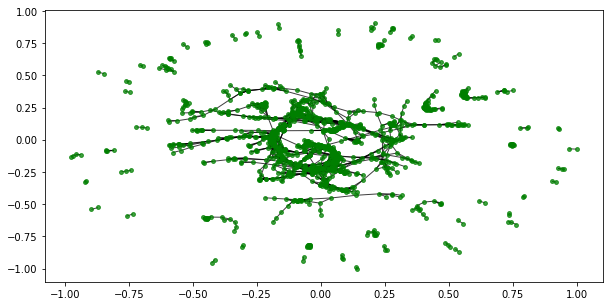

In [30]:
g_50 = nx.Graph()
for c in clusters_50 :
    g_50.add_edge(*c)
fig = plt.figure(figsize = (10, 5))
nx.draw_networkx(g_50, node_size = 15, with_labels = False, node_color = 'green', alpha = 0.75)
plt.show()

In [31]:
sub_graphs_50 = list(nx.connected_component_subgraphs(g_50))
n = len(sub_graphs_50)
clusters_50_mapper = {}
for i in range(n) :
    clusters_50_mapper[i+1] = list(sub_graphs_50[i].nodes())

In [36]:
clusters_25 = list()
for k, v in dists.items() :
    if v <= 25 :
        clusters_25.append(k)

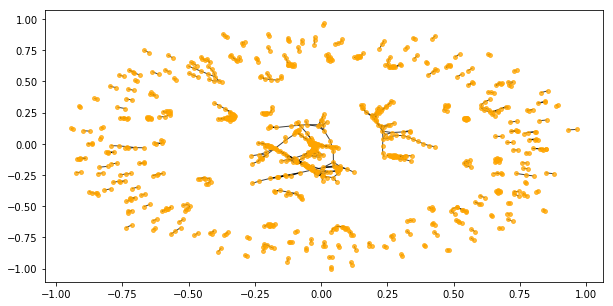

In [37]:
g_25 = nx.Graph()
for c in clusters_25 :
    g_25.add_edge(*c)
fig = plt.figure(figsize = (10, 5))
nx.draw_networkx(g_25, node_size = 15, with_labels = False, node_color = 'orange', alpha = 0.75)
plt.show()

In [38]:
sub_graphs_25 = list(nx.connected_component_subgraphs(g_25))
n = len(sub_graphs_25)
clusters_25_mapper = {}
for i in range(n) :
    clusters_25_mapper[i+1] = list(sub_graphs_25[i].nodes())

In [48]:
def map_cluster(x, mapper) :
    for k, v in mapper.items() :
        if x in v :
            return int(k)

School by school

In [21]:
###===###
keycols = ['UNITID', 'INSTNM', 'LOCALE', 'County', 'STABBR', 'Zipcodes', 'Lat', 'Lon', 'FIPS']

In [22]:
###===###
df_geo = df_all[keycols]

PROBLEM WITH DIFFERING SEARCH DIST LEVELS - WILL NEED TO GET DIFFERENT METRIC THAN JUST LOCALE AS NOT ACCURATE

In [205]:
search_dist = dict(zip(np.sort(df_geo['LOCALE'].dropna().unique())[1:], [75, 75, 75, 50, 50, 50, 25, 25, 25, 10, 10, 10]))

In [106]:
adj_schools_dict = {}

In [43]:
for s in df_geo['UNITID'] :
    adjacent_schools = list()
    locale = df_geo.loc[df_geo['UNITID'] == s, 'LOCALE'].item()
    if locale > 0 :
        searchdist = search_dist[locale]
        for k in dists.keys() :
            if s in k :
                if dists[k] <= searchdist :
                    adjacent_schools.append(k[0])
                    adjacent_schools.append(k[1])
        adj_schools_dict[s] = list(np.unique(adjacent_schools))
    else :
        adj_schools_dict[s] = np.nan 

NameError: name 'search_dist' is not defined

In [107]:
#FOR NOW - UNIFORM SEARCH DISTANCE
for s in df_geo['UNITID'] :
    adjacent_schools = list()
    searchdist = 20
    for k in dists.keys() :
        if s in k :
            if dists[k] <= searchdist :
                adjacent_schools.append(k[0])
                adjacent_schools.append(k[1])
    adj_schools_dict[s] = list(np.unique(adjacent_schools))

In [108]:
df_geo['ADJ_SCHOOLS'] = df_geo['UNITID'].map(adj_schools_dict)

C:\Users\jbachlombardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [3]:
#ENTERING HERE ALL BOXES EITH ###===### AT TOP TO ADD ADJACENT FIPS
df_add_fips = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/merged_all_scorecard_indicators_longitudinal_zips_RESET FROM HERE 42919_adjacents.csv')

In [23]:
###===###
school_county_mapper = pd.Series(df_geo['County'].values, index = df_geo['UNITID'].values).to_dict()
school_fips_mapper = pd.Series(df_geo['FIPS'].values, index = df_geo['UNITID'].values).to_dict()

In [29]:
###===###
def school_to_fips(x) :
    x = literal_eval(x)
    try :
        if len(x) > 1 :
            fips_list = list()
            for s in x :
                fips_list.append(school_fips_mapper[s])
            if len(np.unique(fips_list)) > 1 :
                return list(np.unique(fips_list))
            else :
                return np.nan
        else :
            return np.nan
    except : 
        return np.nan

In [16]:
def school_to_county(x) :
    try :
        if len(x) > 1 :
            county_list = list()
            for s in x :
                county_list.append(school_county_mapper[s])
            if len(np.unique(county_list)) > 1 :
                return list(np.unique(county_list))
            else :
                return np.nan
        else :
            return np.nan
    except : 
        return np.nan

In [32]:
###===###
df_add_fips['ADJ_FIPS'] = df_add_fips['ADJ_SCHOOLS'].apply(school_to_fips)

In [33]:
df_add_fips.to_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/merged_all_scorecard_indicators_longitudinal_zips_fipsadj_RESET FROM HERE 051419_adjacents.csv')

In [111]:
df_geo['ADJ_COUNTIES'] = df_geo['ADJ_SCHOOLS'].apply(school_to_county)

C:\Users\jbachlombardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [112]:
df_geo.to_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/df_geo_all_REDONE START FROM HERE.csv')

In [118]:
merged_all = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/merged_all_scorecard_indicators_longitudinal_zips_RESET FROM HERE 42919.csv')

In [119]:
new_cols_geo = list(set(df_geo.columns) - set(merged_all.columns))

In [120]:
merged_all_adj = merged_all.set_index('UNITID').merge(df_geo.set_index('UNITID')[new_cols_geo], left_index = True, right_index = True)

In [121]:
merged_all_adj.to_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/merged_all_scorecard_indicators_longitudinal_zips_RESET FROM HERE 42919_adjacents.csv')